In [1]:
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
from tqdm.autonotebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2


tqdm.pandas()


/tmp/ipykernel_1501/1111487965.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
crop_height, crop_width = 256, 1024


def flip_and_crop(img, x, height, y, width):
    img = img[::-1]  # flip vertically
    img = img[x:x+height, y:y+width]  # crop
    return img


In [3]:
def get_droplet_profile(img_path, crop_base):
    img = plt.imread(img_path)

    img = flip_and_crop(img, crop_base, crop_height, 0, crop_width)

    # process the image so that it will be easy to distinguish droplet profile
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.bilateralFilter(img, 9, 32, 32)
    img = cv2.Canny(img, 90, 0)
    kernel = np.ones((3, 3), np.uint8)
    img = cv2.dilate(img, kernel, iterations=2)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    # extract the droplet profile
    profile_inv = np.argmax(img[::-1], axis=0)
    profile = img.shape[0] - profile_inv
    profile[profile == img.shape[0]] = 0
    droplet_profile = profile

    return droplet_profile


In [4]:
def shift(arr, num, cval=np.nan):
    # https://stackoverflow.com/questions/30399534/shift-elements-in-a-numpy-array
    # shift the last dimension
    result = np.empty_like(arr)
    if num > 0:
        result[..., :num] = cval
        result[..., num:] = arr[..., :-num]
    elif num < 0:
        result[..., num:] = cval
        result[..., :num] = arr[..., -num:]
    else:
        result[:] = arr
    return result


In [5]:
def get_longest_droplet(droplet_profiles):
    droplet_lengths = np.count_nonzero(droplet_profiles, axis=1)
    longest_droplet = droplet_lengths.argmax()
    return longest_droplet


In [6]:
def normalize_profiles(droplet_profiles, longest_droplet):
    # the longest droplet define the absolute x coordinate system
    center = droplet_profiles[longest_droplet].argmax()

    # shift the droplet profiles to align with the absolute x coordinate system
    offset = 1024//2 - center
    droplet_profiles = shift(droplet_profiles, offset, cval=0)

    # normalize the droplet profiles
    droplet_profiles = droplet_profiles / crop_height

    return droplet_profiles


In [7]:
def process_experiment(dir_path, crop_base):
    img_paths = sorted(dir_path.rglob('*.jpg'))

    droplet_profiles = np.empty((len(img_paths), crop_width))
    for i, img_path in enumerate(img_paths):
        droplet_profiles[i] = get_droplet_profile(img_path, crop_base)

    longest_droplet = get_longest_droplet(droplet_profiles)
    droplet_profiles = normalize_profiles(droplet_profiles, longest_droplet)
    return droplet_profiles


In [8]:
dir_paths = []
dir_paths += sorted((Path.cwd() / 'Machine Learning' / 'W').glob('*'))
dir_paths += sorted((Path.cwd() / 'Machine Learning' / 'SW').glob('*'))
dir_paths += sorted((Path.cwd() / 'Machine Learning' / 'GW').glob('*'))

exp_df = pd.DataFrame({'exp_path': dir_paths})
exp_df['liquid_type'] = exp_df['exp_path'].apply(
    lambda x: x.parent.name.split('_')[0])


def get_voltage(liquid_type, exp_path):
    return int(exp_path.name[len(liquid_type):])


exp_df['voltage'] = exp_df.apply(lambda x: get_voltage(
    x['liquid_type'], x['exp_path']), axis=1)


crop_bases = {'GW': 145, 'SW': 230, 'W': 230}
exp_df['crop_base'] = exp_df['liquid_type'].apply(lambda x: crop_bases[x])


experiments_path = Path.cwd() / 'csv' / 'experiments.csv'
exp_df.to_csv(experiments_path, index=False)
exp_df.head()


,exp_path,liquid_type,voltage,crop_base
0,/home/galah92/playground-voltage/Machine Learn...,W,100,230
1,/home/galah92/playground-voltage/Machine Learn...,W,1000,230
2,/home/galah92/playground-voltage/Machine Learn...,W,150,230
3,/home/galah92/playground-voltage/Machine Learn...,W,200,230
4,/home/galah92/playground-voltage/Machine Learn...,W,250,230


In [9]:
# with ProcessPoolExecutor() as executor:
#     futures = executor.map(
#         process_experiment, exp_df['exp_path'], exp_df['crop_base'])
#     exp_profiles = list(tqdm(futures, total=len(exp_df)))

exp_profiles = [process_experiment(dir_path, crop_base)
                for dir_path, crop_base
                in tqdm(zip(exp_df['exp_path'], exp_df['crop_base']), total=len(exp_df))]


exp_df['profile'] = [Path.cwd() / 'csv' / f'profile_{i}.npy'
                     for i
                     in range(len(exp_profiles))]
exp_df.to_csv(experiments_path, index=False)

for profile_path, profile in zip(exp_df.profile, exp_profiles):
    np.save(profile_path, profile)

exp_df.head()


  0%|          | 0/47 [00:00<?, ?it/s]

,exp_path,liquid_type,voltage,crop_base,profile
0,/home/galah92/playground-voltage/Machine Learn...,W,100,230,/home/galah92/playground-voltage/csv/profile_0...
1,/home/galah92/playground-voltage/Machine Learn...,W,1000,230,/home/galah92/playground-voltage/csv/profile_1...
2,/home/galah92/playground-voltage/Machine Learn...,W,150,230,/home/galah92/playground-voltage/csv/profile_2...
3,/home/galah92/playground-voltage/Machine Learn...,W,200,230,/home/galah92/playground-voltage/csv/profile_3...
4,/home/galah92/playground-voltage/Machine Learn...,W,250,230,/home/galah92/playground-voltage/csv/profile_4...


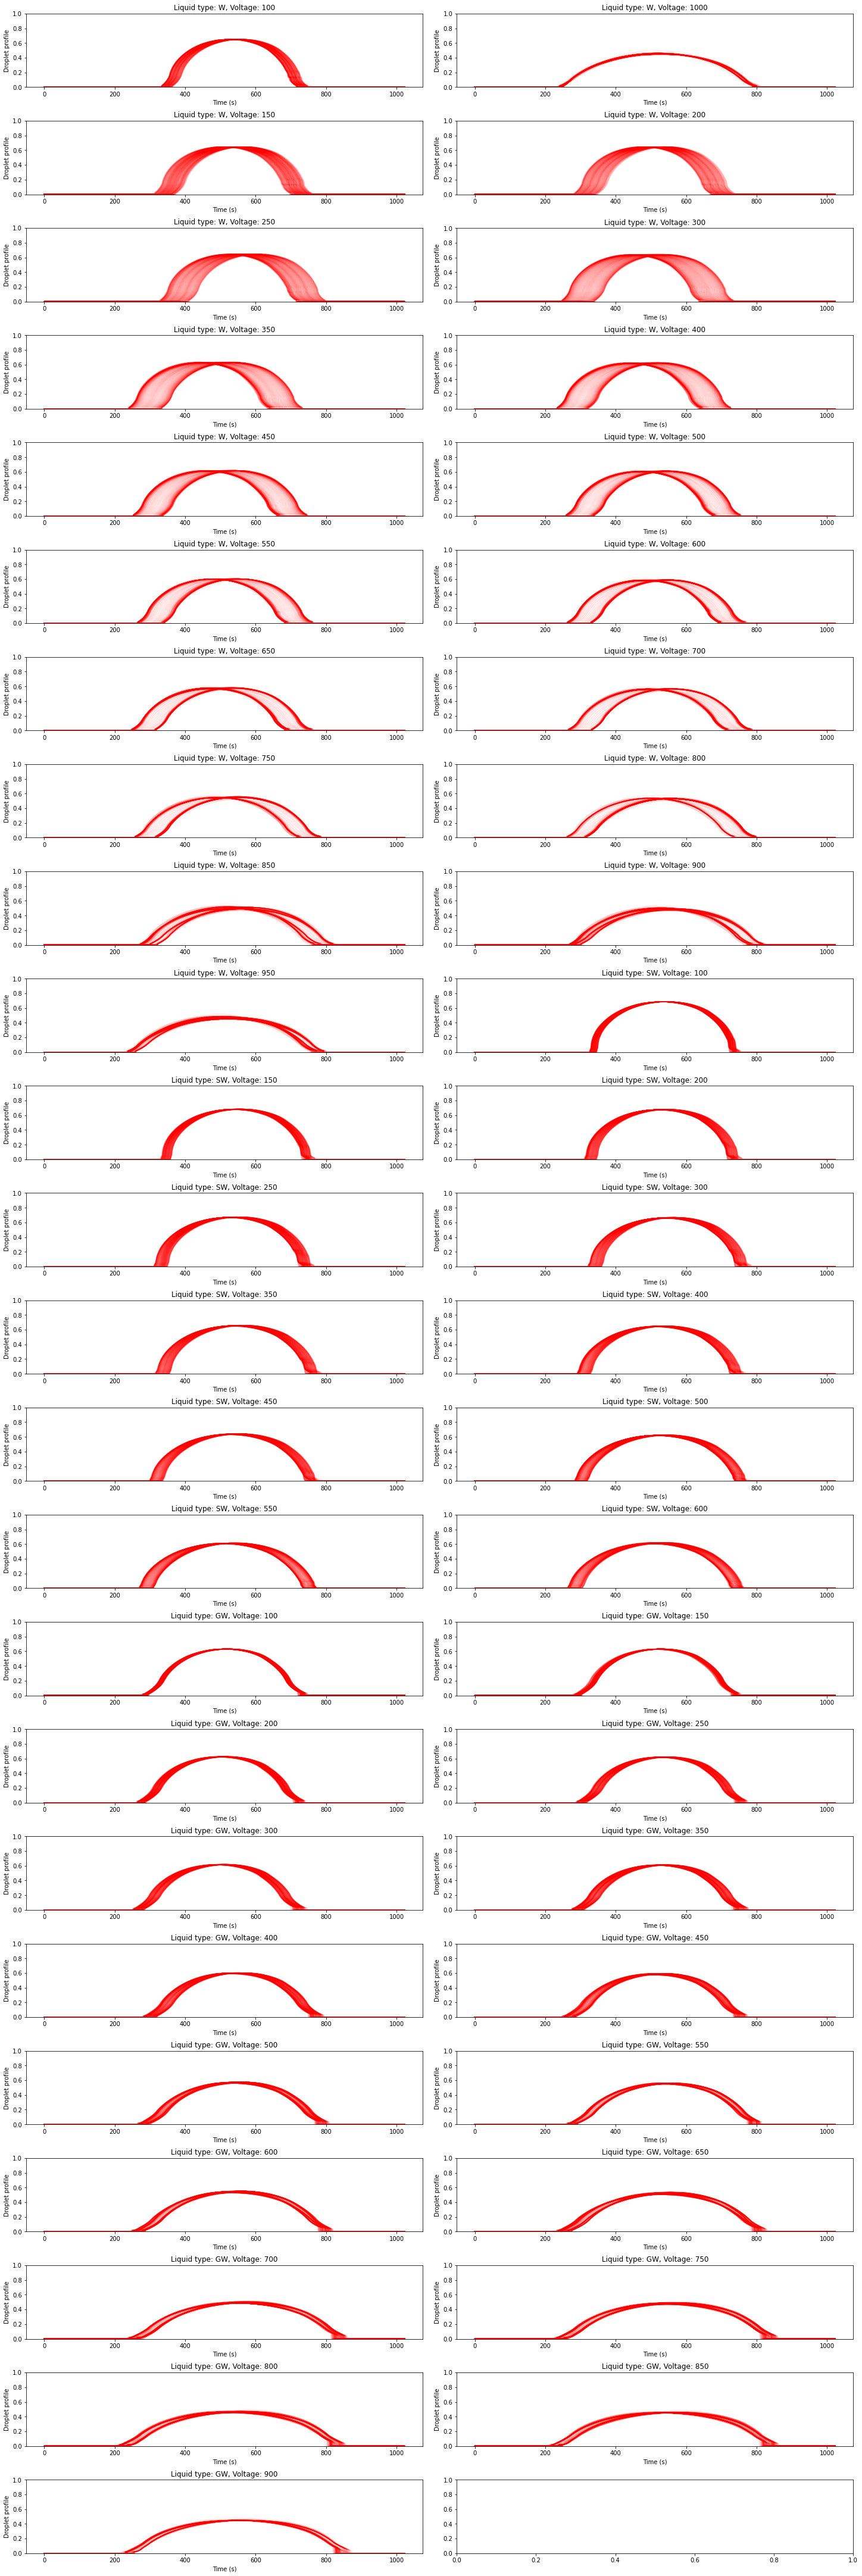

In [10]:
num_experiments = len(dir_paths)
fig, axes = plt.subplots(np.ceil(num_experiments / 2).astype(int), 2,
                         figsize=(20, 60), constrained_layout=True)

for i, ax in enumerate(fig.axes[:num_experiments]):
    ax.plot(exp_profiles[i].T, color="#ff000008")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Droplet profile")
    title = f"Liquid type: {exp_df.liquid_type[i]}, Voltage: {exp_df.voltage[i]}"
    ax.set_title(title)
    ax.set_ylim(0, 1)

fig_path = Path.cwd() / 'droplet_profiles'
fig.savefig(fig_path, facecolor='white', transparent=False, dpi=300)
